# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:03<00:00, 49.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

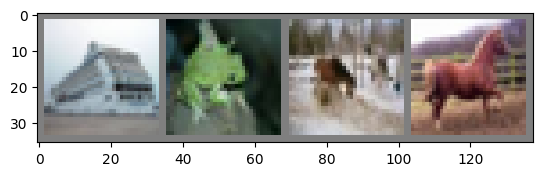

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.main_branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.shortcut = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.pooling = nn.AvgPool2d(8)
        self.linear = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        main_part = self.main_branch(x)
        main_part += self.shortcut(x)
        out = self.pooling(torch.relu(main_part))
        return self.linear(torch.flatten(out, start_dim=1))

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (main_branch): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pooling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = F.cross_entropy(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item())

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item())

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.503102629450601, train acc: 0.4653466962809101
 val loss: 1.2678370346414283, val acc: 0.5529033688788718

Epoch 1
 train loss: 1.175177334322572, train acc: 0.5878737921906564
 val loss: 1.1127608532601214, val acc: 0.6128324468085107

Epoch 2
 train loss: 1.0675855100263842, train acc: 0.6300315030967949
 val loss: 1.0460812659973795, val acc: 0.6313608156873824

Epoch 3
 train loss: 1.0095389249991673, train acc: 0.6462890115690841
 val loss: 1.0223957987541847, val acc: 0.6449911348363186

Epoch 4
 train loss: 0.9769975988694911, train acc: 0.658400528936543
 val loss: 1.0198745111201672, val acc: 0.64878102845334

Epoch 5
 train loss: 0.9474165148665308, train acc: 0.6701529446641967
 val loss: 0.9365947728461408, val acc: 0.6747783688788719

Epoch 6
 train loss: 0.9209349735127507, train acc: 0.680628101394207
 val loss: 0.9358692821035994, val acc: 0.6773049646235527

Epoch 7
 train loss: 0.901895039151312, train acc: 0.6864063724521309
 val loss: 0.942713

Посчитайте точность на тестовой выборке:

In [ ]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.9155338243314415, accuracy = 0.6814291401273885


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

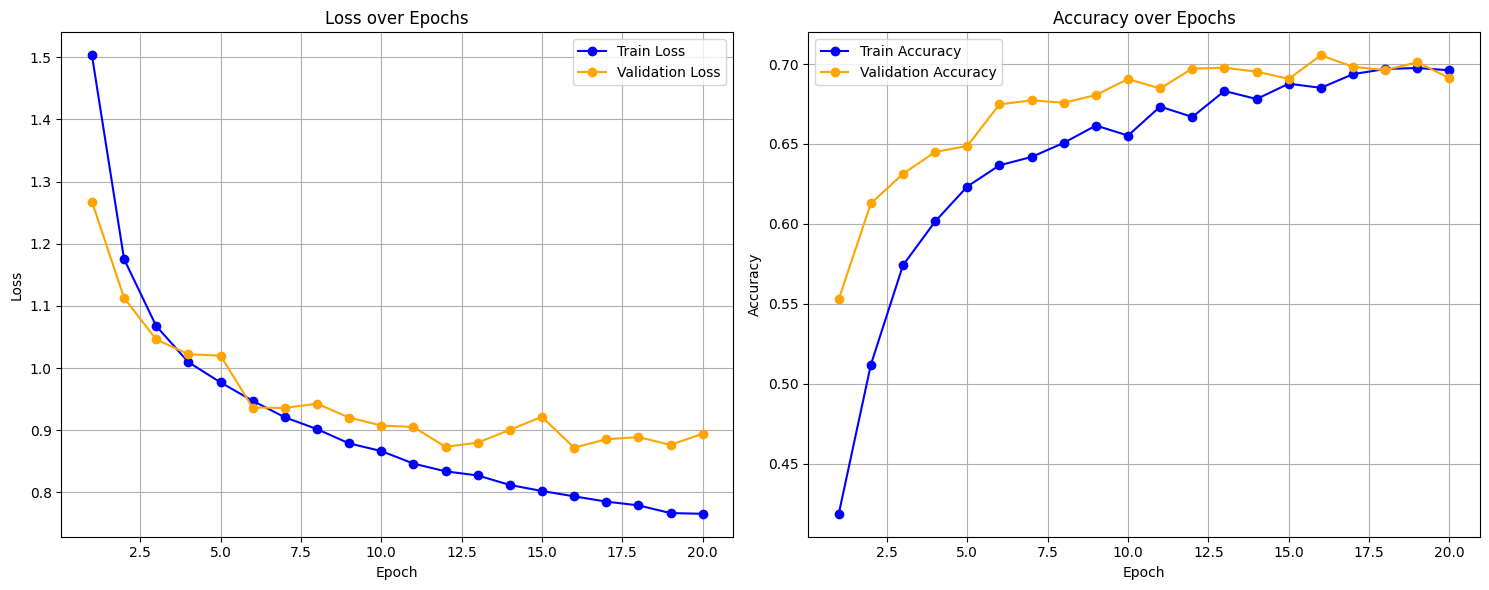

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(range(1, 21), [np.mean(train_loss_log[i*547: (i+1)*547]) for i in range(20)], label='Train Loss', color='blue', marker='o')
axs[0].plot(range(1, len(val_loss_log) + 1), val_loss_log, label='Validation Loss', color='orange', marker='o')
axs[0].set_title('Loss over Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(1, 21), [np.mean(train_acc_log[i*547: (i+1)*547]) for i in range(20)], label='Train Accuracy', color='blue', marker='o')
axs[1].plot(range(1, len(val_acc_log) + 1), val_acc_log, label='Validation Accuracy', color='orange', marker='o')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5064743793206852, train acc: 0.464510152828105
 val loss: 1.2832812770884088, val acc: 0.5501994680851063

Epoch 1
 train loss: 1.1678862823428793, train acc: 0.5932848002400651
 val loss: 1.1398216696495707, val acc: 0.5970744680851063

Epoch 2
 train loss: 1.066865986400374, train acc: 0.6296397558731832
 val loss: 1.019264593022935, val acc: 0.6522828015875309

Epoch 3
 train loss: 1.005746847314852, train acc: 0.648345684329596
 val loss: 1.104540989754048, val acc: 0.6185283688788719

Epoch 4
 train loss: 0.9623900101651222, train acc: 0.667378068733041
 val loss: 0.9540415177954004, val acc: 0.667154255319149

Epoch 5
 train loss: 0.9316056078705099, train acc: 0.6763270436300874
 val loss: 0.9487009842345056, val acc: 0.6714317377577437

Epoch 6
 train loss: 0.9126691120852064, train acc: 0.6831540545990088
 val loss: 0.9289040372726766, val acc: 0.6816046100981692

Epoch 7
 train loss: 0.8950749227617079, train acc: 0.6886752416708352
 val loss: 1.0498861

Посчитайте точность на тестовой выборке:

In [ ]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8452602598317869, accuracy = 0.707703025477707


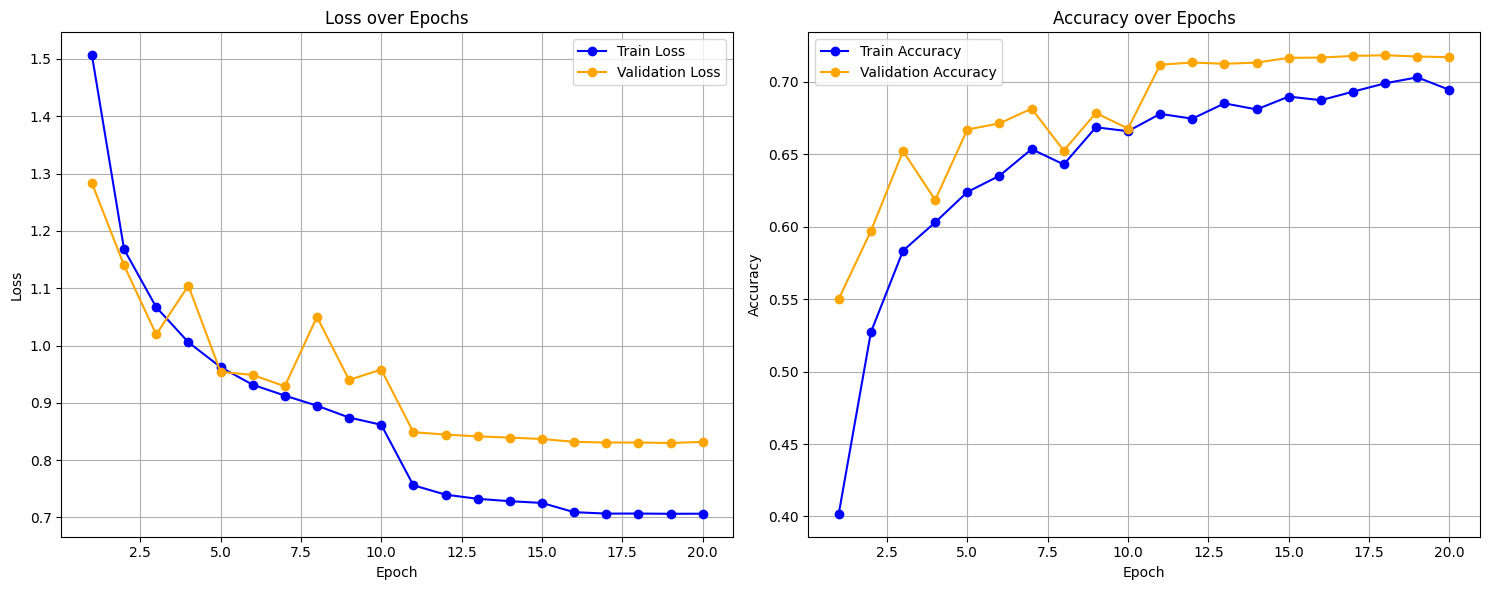

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(range(1, 21), [np.mean(tr_loss_log[i*547: (i+1)*547]) for i in range(20)], label='Train Loss', color='blue', marker='o')
axs[0].plot(range(1, len(val_loss_log) + 1), val_loss_log, label='Validation Loss', color='orange', marker='o')
axs[0].set_title('Loss over Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(1, 21), [np.mean(tr_acc_log[i*547: (i+1)*547]) for i in range(20)], label='Train Accuracy', color='blue', marker='o')
axs[1].plot(range(1, len(val_acc_log) + 1), val_acc_log, label='Validation Accuracy', color='orange', marker='o')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8336942516253678, train acc: 0.3605624837239002
 val loss: 1.6037511855997937, val acc: 0.4394281914893617

Epoch 1
 train loss: 1.5381873560561994, train acc: 0.46289827640575293
 val loss: 1.4430873120084722, val acc: 0.49565602845333995

Epoch 2
 train loss: 1.4103486566264625, train acc: 0.5069616740974692
 val loss: 1.350991601132332, val acc: 0.5207225178150421

Epoch 3
 train loss: 1.3330672486826531, train acc: 0.5335515148025108
 val loss: 1.2972428329447483, val acc: 0.5450797872340426

Epoch 4
 train loss: 1.2788826105145694, train acc: 0.5530531797592121
 val loss: 1.245514777619788, val acc: 0.5627216313747649

Epoch 5
 train loss: 1.2375566932139492, train acc: 0.5686455341754055
 val loss: 1.2075033418675687, val acc: 0.5757978723404256

Epoch 6
 train loss: 1.195655883557182, train acc: 0.5833605380773108
 val loss: 1.162333704816534, val acc: 0.5922872340425532

Epoch 7
 train loss: 1.1576192186127197, train acc: 0.5947212065813529
 val loss: 1.1

In [ ]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.9739269109288599, accuracy = 0.6642117834394905


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=4, power=1.0)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

Epoch 0
 train loss: 1.8080647399264236, train acc: 0.3729922956696812
 val loss: 1.5977469058746987, val acc: 0.4459219859001484

Epoch 1
 train loss: 1.5320495702666819, train acc: 0.4660567380828439
 val loss: 1.4663163367738115, val acc: 0.48541666675121226

Epoch 2
 train loss: 1.437774202287524, train acc: 0.49688234527542563
 val loss: 1.4008923586378705, val acc: 0.507313829787234

Epoch 3
 train loss: 1.389670733342005, train acc: 0.5152863019999028
 val loss: 1.3700428780089033, val acc: 0.5194148936170213

Epoch 4
 train loss: 1.3721605513169952, train acc: 0.5211298642254398
 val loss: 1.3664518533868992, val acc: 0.5189937944107867

Epoch 5
 train loss: 1.3721554957098674, train acc: 0.5190487072498314
 val loss: 1.367215055607735, val acc: 0.5186613476022761

Epoch 6
 train loss: 1.3716138847567263, train acc: 0.5229090493601463
 val loss: 1.368408865117012, val acc: 0.5186613476022761

Epoch 7
 train loss: 1.3727385670872885, train acc: 0.5215175307102133
 val loss: 1.36

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

Epoch 0
 train loss: 1.7976759680882233, train acc: 0.37067853881410534
 val loss: 1.581078010924319, val acc: 0.43936170212765957

Epoch 1
 train loss: 1.504837397683473, train acc: 0.47036595721567354
 val loss: 1.4347136715625195, val acc: 0.4925531914893617

Epoch 2
 train loss: 1.4026375786695882, train acc: 0.5075003265026936
 val loss: 1.353257112807416, val acc: 0.5260859929500742

Epoch 3
 train loss: 1.3369156778185634, train acc: 0.5319029120030307
 val loss: 1.3010558610266827, val acc: 0.5457003546522019

Epoch 4
 train loss: 1.2922583707289896, train acc: 0.5466709650194841
 val loss: 1.2620417934782961, val acc: 0.5586657801841167

Epoch 5
 train loss: 1.2513203012877887, train acc: 0.5600597414935529
 val loss: 1.2472465307154554, val acc: 0.5579565603682335

Epoch 6
 train loss: 1.214005584472712, train acc: 0.576154021992326
 val loss: 1.184430095489989, val acc: 0.5873005319148936

Epoch 7
 train loss: 1.1791459393893562, train acc: 0.5883226691042047
 val loss: 1.17

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

Epoch 0
 train loss: 1.4980960306345437, train acc: 0.46052330895795246
 val loss: 1.292660297485108, val acc: 0.5363475178150421

Epoch 1
 train loss: 1.238691708396514, train acc: 0.5594149908592322
 val loss: 1.1839589669349346, val acc: 0.5811613476022761

Epoch 2
 train loss: 1.1021840141939725, train acc: 0.6101503330785134
 val loss: 1.0408633125589248, val acc: 0.6352171986661059

Epoch 3
 train loss: 1.024239793338113, train acc: 0.639829263608678
 val loss: 1.0046161816475239, val acc: 0.6505762412192974

Epoch 4
 train loss: 0.9751020694999416, train acc: 0.6611631628146337
 val loss: 0.9478126574069896, val acc: 0.6724290781832756

Epoch 5
 train loss: 0.940316229786254, train acc: 0.6730788065702867
 val loss: 0.9170325659691019, val acc: 0.6808732271194458

Epoch 6
 train loss: 0.910663659437483, train acc: 0.6831826194984604
 val loss: 0.9265073317162534, val acc: 0.6739140071767442

Epoch 7
 train loss: 0.8868894535619118, train acc: 0.691503166716539
 val loss: 0.93099

CyclicLR позволил чуть-чуть улучшить результат, но другие приемы заметно ухудшили.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

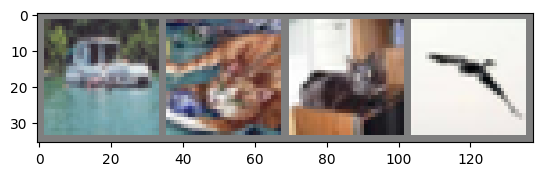

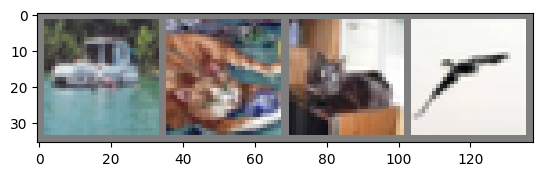

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4594713347049693, train acc: 0.48092272795968344
 val loss: 1.1973296064011594, val acc: 0.5749778369639782

Epoch 1
 train loss: 1.1609839233663444, train acc: 0.5955169430816414
 val loss: 1.0808983782504467, val acc: 0.6244459220703612

Epoch 2
 train loss: 1.0606767284586835, train acc: 0.632149386340565
 val loss: 1.0177129065736812, val acc: 0.6533909574468085

Epoch 3
 train loss: 1.005233947712063, train acc: 0.6513490794563642
 val loss: 0.983755712052609, val acc: 0.6616134752618505

Epoch 4
 train loss: 0.9706709881805197, train acc: 0.6632973687958238
 val loss: 1.0425992922579987, val acc: 0.6362367021276596

Epoch 5
 train loss: 0.944083026383869, train acc: 0.6733073257658991
 val loss: 0.9509081064386571, val acc: 0.6675088654173181

Epoch 6
 train loss: 0.9208542675161274, train acc: 0.6807586837294333
 val loss: 0.914835750042124, val acc: 0.682003546268382

Epoch 7
 tra

Посчитайте точность на тестовой выборке:

In [ ]:
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

loss = 0.8063512548899195, accuracy = 0.7248208598726115


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
        [transforms.RandomGrayscale(p=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')


Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4757463195424194, train acc: 0.4767114455782735
 val loss: 1.2407306770060924, val acc: 0.554565602921425

Epoch 1
 train loss: 1.17193348577733, train acc: 0.5909873662308758
 val loss: 1.0810562176907317, val acc: 0.6248005319148936

Epoch 2
 train loss: 1.0599624193128763, train acc: 0.6335857926818527
 val loss: 1.0846961335932954, val acc: 0.6292109930768927

Epoch 3
 train loss: 1.0049054199860343, train acc: 0.6521244124259112
 val loss: 1.0344476271182932, val acc: 0.6452127659574468

Epoch 4
 train loss: 0.9657397038104112, train acc: 0.6656396905508513
 val loss: 1.0233304016133573, val acc: 0.6506648936170213

Epoch 5
 train loss: 0.9387171270642464, train acc: 0.6744540024283163
 val loss: 1.0615523919146113, val acc: 0.6318705674181593

Epoch 6
 train loss: 0.9114320381685846, train acc: 0.686716505661743
 val loss: 0.9513893807187993, val acc: 0.6738696808510638

Epoch 7
 tr

In [ ]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')


Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6321180873640713, train acc: 0.40595618963677443
 val loss: 1.4327622220871297, val acc: 0.48328900717674417

Epoch 1
 train loss: 1.3613134107162572, train acc: 0.5157351789134512
 val loss: 1.2981054686485454, val acc: 0.5388076241980208

Epoch 2
 train loss: 1.2604430097766506, train acc: 0.5527185623345036
 val loss: 1.2380496575477276, val acc: 0.564627659574468

Epoch 3
 train loss: 1.2055463675389124, train acc: 0.5737627318615888
 val loss: 1.186868456576733, val acc: 0.5860593973322118

Epoch 4
 train loss: 1.155347780728035, train acc: 0.5893836511772337
 val loss: 1.1878546052790702, val acc: 0.5831117021276596

Epoch 5
 train loss: 1.1236360683301685, train acc: 0.6020174981035306
 val loss: 1.1788116193832234, val acc: 0.5800753546522018

Epoch 6
 train loss: 1.0940734168729136, train acc: 0.6148921063874714
 val loss: 1.1224771948570902, val acc: 0.5994459220703612

Epoch 7


In [ ]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6383870312675044, train acc: 0.40416476234003657
 val loss: 1.4933007539586818, val acc: 0.45917553191489363

Epoch 1
 train loss: 1.3645629900247132, train acc: 0.5134744711724234
 val loss: 1.2910058483164362, val acc: 0.545567376055616

Epoch 2
 train loss: 1.2578097872803808, train acc: 0.5552608383856918
 val loss: 1.2336190216084744, val acc: 0.5672650710065315

Epoch 3
 train loss: 1.2029873654654955, train acc: 0.5775088143740973
 val loss: 1.1762293422475774, val acc: 0.5871232271194458

Epoch 4
 train loss: 1.155058112288306, train acc: 0.5925910812845178
 val loss: 1.181400775655787, val acc: 0.5880319148936171

Epoch 5
 train loss: 1.1197059791964195, train acc: 0.6055473034734917
 val loss: 1.1713626539453548, val acc: 0.5841090425531915

Epoch 6
 train loss: 1.0917206709520038, train acc: 0.6127293353978633
 val loss: 1.127857818502061, val acc: 0.6013076241980208

Epoch 7
 

In [ ]:
transform = transforms.Compose(
        [transforms.RandomGrayscale(p=0.1),
         transforms.RandomVerticalFlip(),
         transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)
loss, accuracy = test(net, test_loader)
print(f'loss = {loss}, accuracy = {accuracy}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.8297939481421406, train acc: 0.33695971535372343
 val loss: 1.7038946166951605, val acc: 0.37734929082241464

Epoch 1
 train loss: 1.6683097397823439, train acc: 0.4017000196184929
 val loss: 1.6134973906456156, val acc: 0.4193927305809995

Epoch 2
 train loss: 1.6126097516996116, train acc: 0.4233236485033192
 val loss: 1.5618599404679967, val acc: 0.446343085106383

Epoch 3
 train loss: 1.5768642329646638, train acc: 0.440168777811026
 val loss: 1.5835207994948042, val acc: 0.43550531914893614

Epoch 4
 train loss: 1.5356218108747297, train acc: 0.4508316466751657
 val loss: 1.5308290364894461, val acc: 0.4556959220703612

Epoch 5
 train loss: 1.5221052132751214, train acc: 0.4560916688586066
 val loss: 1.5173707119962003, val acc: 0.4604831561129144

Epoch 6
 train loss: 1.4952439723546587, train acc: 0.4664484853064556
 val loss: 1.4691611878415372, val acc: 0.4767287234042553

Epoch 

Как видим, учлушить не получилось, но сравнимым был gray_scale. С человеческой точки зрения это логично, т.к. мы просто изменили цвета на картинке, распознавать тяжелее нам не стало. Возможно остальные аугментации имели бы смысл, коль больше эпох мы попробовали (не давали бы переобучиться), т.к. пока есть основания полагать, что наша модеь еще имеет потенциал для улучшения. Заметим, что совокупность хуже чем каждый по отдельности, т.к. возможно таким образом мы слишком сильно запутываем нейросеть и получаем то, что получаем.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
!pip install wandb
import wandb

In [ ]:
wandb.login()

True

In [ ]:
wandb.init(
    project="my-awesome-project",

    config={
    "learning_rate": 0.1,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 20,
    }
)

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = F.cross_entropy(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item())

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item())

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        wandb.log({'train_loss':np.mean(train_loss), 'train_acc':np.mean(train_acc), 'val_loss':val_loss, 'val acc':val_acc})

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)
wandb.finish()

train_acc,▁▄▅▆▆▇▇▇▇▇▇▇▇███████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val acc,▁▄▅▆▅▆▆▇▇▇▇▇▇███▅███
val_loss,█▅▅▃▄▃▃▂▂▂▃▂▂▂▁▁▄▁▁▁
train_acc,0.74138
train_loss,0.74077
val acc,0.70851
val_loss,0.85585


Ссылки выше вроде как как раз ведут на графики.